## Md Asif Rahman, ID. 114084345

## Generative Adversarial Networks

A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in June 2014 [1]. GAN composes of two deep networks, the generator and the discriminator. Two neural networks contest with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss). This is a type of discriminative learning. Through the discriminative learning we can discriminate between photos of cats and photos of dogs. In that case, deep neural networks learn mappings from the given dataset. 

With a given dataset, with/without any labels, we might want to learn a model that concisely captures the characteristics of this data. Given such a model, we could sample synthetic data examples that resemble the distribution of the training data. For example, given a large corpus of photographs of faces, we might want to be able to generate a new photorealistic image that looks like it might plausibly have come from the same dataset. This kind of learning is called generative modeling. GAN is a clever technique to o leverage the power of discriminative models to get good generative models. 

At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data [2]. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution [2]. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way. In other words, rather than just training a model to say "hey, these two datasets do not look like they came from the same distribution", they use the [two-sample test](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) to provide training signals to a generative model. This allows us to improve the data generator until it generates something that resembles the real data. At the very least, it needs to fool the classifier. Even if our classifier is a state of the art deep neural network.

<img src="gan.svg">

|  | 
|:--:|
| *Fig. 1: GAN [2]* |


The GAN architecture is illustrated in Fig. 1 [2]. As you can see, there are two pieces in GAN architecture - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. If we are dealing with images, this needs to generate images. If we are dealing with speech, it needs to generate audio sequences, and so on. We call this the generator network. The second component is the discriminator network. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on.


The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf x$, such as using a dense layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is $1$ and $0$ for the fake data. We train the discriminator to minimize the cross-entropy loss, *i.e.*,

$$ \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},$$

For the generator, it first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, *e.g.*, a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$. We often call $\mathbf z$ as the latent variable.
It then applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal of the generator is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, *i.e.*, we want $D( G(\mathbf z)) \approx 1$.
In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, *i.e.*,

$$ \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.$$

If the generator does a perfect job, then $D(\mathbf x')\approx 1$ so the above loss near 0, which results the gradients are too small to make a good progress for the discriminator. So commonly we minimize the following loss:

$$ \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, $$

which is just feed $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.


To sum up, $D$ and $G$ are playing a "minimax" game with the comprehensive objective function:

$$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.$$

Many of the GANs applications are in the context of images. The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.

The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.

### Problem Statement:

Alkali–silica reaction (ASR) is a material degradation mechanism that occurs in concrete structures. ASR is the most common source of concrete deterioration worldwide and is of more significance in the United States. It is a chemical reaction occurring between the reactive siliceous aggregate particles and hydroxyl ions of the pore solution in hardened concrete [3]. It's a long-time degradation process [4], and the lab tests within this time frame might not be feasible in terms of the inherent chemical reaction. Therefore, a rigorous observation and prediction of ASR can provide useful information regarding the potential ASR expansion or the degree (extent) of ASR over time. However, a very small ASR data are available from the existing lab tests.

Within this context, I will utilize GAN for the sample data generation of ASR expansion based on my simulated data under the stochastic weather conditions. 

In [1]:
import time
from datetime import timedelta
start_time = time.monotonic()

Let's start by importing torch along with other helpful libraries. 

In [2]:
pip install torchvision 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(111) #setting up a sed value to get same results for each process

### Getting the Data:

Let's read the data for the available experimental results of the ASR expansion within a 1 year timeframe. 

In [5]:
import pandas as pd
import numpy as np
df_raw=pd.read_csv("Experiment.csv")
T = ['8', '10', '9', '12', '11', '14', '16', '16', '17']
df_raw['Temp'] = T
df_raw

,Time,Exp,Temp
0,0.019812,0.001000,8
1,0.076607,0.004000,10
2,0.153213,0.012340,9
3,0.250953,0.019480,12
4,0.500585,0.070780,11
5,0.628234,0.094455,14
6,0.747575,0.110000,16
7,0.885994,0.131614,16
8,0.999849,0.145450,17


### Describing the dataset:

In [6]:
print("="*50)
print("First Five Rows ","\n")
print(df_raw.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_raw.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df_raw.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df_raw.isnull().sum(),"\n")

First Five Rows  

       Time    Exp Temp
0  0.019812  0.001    8
1  0.076607  0.004   10 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9 non-null      float64
 1   Exp     9 non-null      float64
 2   Temp    9 non-null      object 
dtypes: float64(2), object(1)
memory usage: 344.0+ bytes
None 

Describe the Dataset  

           Time       Exp
count  9.000000  9.000000
mean   0.473647  0.065458
std    0.364427  0.057550
min    0.019812  0.001000
25%    0.153213  0.012340
50%    0.500585  0.070780
75%    0.747575  0.110000
max    0.999849  0.145450 

Null Values t  

Time    0
Exp     0
Temp    0
dtype: int64 



### Setting up the Data:

Let's set up and split the dataset to develop a train set.

In [7]:
#converting dataframe values into a tensor
df = np.float32(df_raw)
dat=torch.from_numpy(df)
torch.set_printoptions(precision=5)
dat

tensor([[1.98121e-02, 1.00000e-03, 8.00000e+00],
        [7.66067e-02, 4.00000e-03, 1.00000e+01],
        [1.53213e-01, 1.23400e-02, 9.00000e+00],
        [2.50953e-01, 1.94800e-02, 1.20000e+01],
        [5.00585e-01, 7.07800e-02, 1.10000e+01],
        [6.28234e-01, 9.44546e-02, 1.40000e+01],
        [7.47575e-01, 1.10000e-01, 1.60000e+01],
        [8.85994e-01, 1.31614e-01, 1.60000e+01],
        [9.99849e-01, 1.45450e-01, 1.70000e+01]])

In [8]:
# prepare the train set
train_data_length = 9 #INPUT=total no. of data entries in the given dataset

train_data = torch.zeros((train_data_length, 3))

train_data[:, 0] = dat[:, 0]

train_data[:, 1] = dat[:, 1]

train_data[:, 2] = dat[:, 2]


train_labels = torch.zeros(train_data_length)

train_set = [

    (train_data[i], train_labels[i]) for i in range(train_data_length)

]

train_set

[(tensor([1.98121e-02, 1.00000e-03, 8.00000e+00]), tensor(0.)),
 (tensor([7.66067e-02, 4.00000e-03, 1.00000e+01]), tensor(0.)),
 (tensor([0.15321, 0.01234, 9.00000]), tensor(0.)),
 (tensor([ 0.25095,  0.01948, 12.00000]), tensor(0.)),
 (tensor([ 0.50058,  0.07078, 11.00000]), tensor(0.)),
 (tensor([ 0.62823,  0.09445, 14.00000]), tensor(0.)),
 (tensor([ 0.74758,  0.11000, 16.00000]), tensor(0.)),
 (tensor([ 0.88599,  0.13161, 16.00000]), tensor(0.)),
 (tensor([ 0.99985,  0.14545, 17.00000]), tensor(0.))]

Let's plot our train data set.

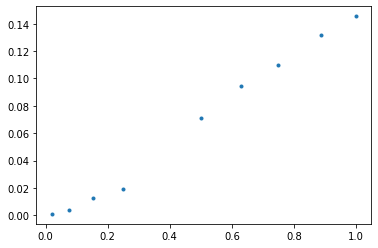

In [9]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

Text(0.5, 0.92, 'Exp vs Temp vs Time')

/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


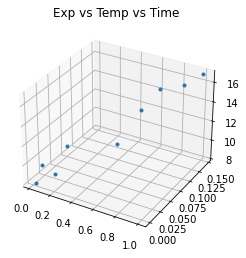

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(train_data[:, 0], train_data[:, 1], train_data[:, 2], ".")
plt.title("Exp vs Temp vs Time") 

In [11]:
# prepare the  data batch
batch_size = 3  #INPUT = divide the dataset to train model in each iterations
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=False  #make sure to NOT shuffle
)

### Initializing the GAN:

I will use a leaky ReLU activation function for both the generator and discriminator. 

Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

### Generator:

Our generator network is a 3 layers linear model. It will literally learn the required parameters to fake things perfectly.

In [12]:
class Generator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(3, 16), #2,16
            #alphas = [0, .2, .4, .6, .8, 1]
            #nn.LeakyReLU(alpha),
            nn.LeakyReLU(), 

            nn.Linear(16, 32), #16, 32

            nn.LeakyReLU(),

            nn.Linear(32, 3),  #32, 2

        )


    def forward(self, x):

        output = self.model(x)

        return output

In [13]:
generator = Generator()

### Discriminator:

For the discriminator let's be a bit more discriminating: a discriminator network with 4 layers and more neurons in it, to make things a bit more interesting. This will force the generator and it's fake data to be more realistic.Thus, the discriminator is a mirror of the generator.

In [14]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(3, 256), #2, 256

            nn.LeakyReLU(),

            nn.Dropout(0.3),

            nn.Linear(256, 128), #256, 128

            nn.LeakyReLU(),

            nn.Dropout(0.3),

            nn.Linear(128, 64), #128, 64

            nn.LeakyReLU(),

            nn.Dropout(0.3),

            nn.Linear(64, 1),  #64, 1

            nn.Sigmoid(),

        )


    def forward(self, x):

        output = self.model(x)

        return output

In [15]:
discriminator = Discriminator()

### Training the GAN:

Let's define a function to train and generate samples from the GAN. Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process.

In [16]:
#loss function
loss_function = nn.BCELoss()
#loss_function = nn.BCEWithLogitsLoss(reduction='sum')

Epoch=[]
Loss_D=[]
Loss_G=[]

#function for the GAN training
def GAN(lr1, lr2, num_epochs):
    
    #optimizer to smooth the training process
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr1)

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr2)
    
    for epoch in range(num_epochs):

        for n, (real_samples, _) in enumerate(train_loader):

            # Data for training the discriminator

            real_samples_labels = torch.ones((batch_size, 1))

            latent_space_samples = torch.randn((batch_size, 3))

            generated_samples = generator(latent_space_samples)

            generated_samples_labels = torch.zeros((batch_size, 1))

            all_samples = torch.cat((real_samples, generated_samples))

            all_samples_labels = torch.cat(

                (real_samples_labels, generated_samples_labels)

            )

            # Training the discriminator

            # computing gradients.

            discriminator.zero_grad()

            output_discriminator = discriminator(all_samples)

            loss_discriminator = loss_function(

                output_discriminator, all_samples_labels)

            loss_discriminator.backward()

            optimizer_discriminator.step()


            # Data for training the generator

            latent_space_samples = torch.randn((batch_size, 3))


            # Training the generator

            generator.zero_grad()

            generated_samples = generator(latent_space_samples)

            output_discriminator_generated = discriminator(generated_samples)

            # Recomputing `fake_Y` is needed since `output_discriminator_generated` is changed
            #fake_Y = discriminator(output_discriminator_generated)
            #loss_generator = loss_function(fake_Y, ones.reshape(fake_Y.shape))
            
            # Use `output_discriminator_generated` from `discriminator` to save computation
            loss_generator = loss_function(

                output_discriminator_generated, real_samples_labels

            )

            loss_generator.backward()

            optimizer_generator.step()

            #convert tensor to array        

            from torch.autograd import Variable
            type(loss_discriminator)  # <class 'torch.Tensor'>

            loss_discriminator = Variable(loss_discriminator, requires_grad=True) #Not necessary this line
            loss_discriminator = loss_discriminator.detach().numpy()

            type(loss_discriminator)  #<class 'numpy.ndarray'>


            type(loss_generator)  # <class 'torch.Tensor'>

            loss_generator = Variable(loss_generator, requires_grad=True)   #Not necessary this line
            loss_generator = loss_generator.detach().numpy()

            type(loss_generator)  #<class 'numpy.ndarray'> 

            # Show loss
            #print(f"Epoch: {epoch} Loss G.: {loss_generator}")    #show results for every epoch              

            if epoch % 10 == 0 and n == batch_size - 1: #show results for every 10 epoch

                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

                #get all results for the loss using append() 

                Epoch.append(epoch)
                Loss_D.append(loss_discriminator)
                Loss_G.append(loss_generator)

    return

Now let's specify the hyperparameters for the GAN training.

In [17]:
#If lr1 is too large compared to lr2, convergence issue happens, i.e., loss gets down to zero immediately 
#or loss plot is more or less a straight line.
lr1 = 0.0003  
lr2 = 0.0001 
num_epochs = 25000 

In [18]:
GAN(lr1, lr2, num_epochs)

Epoch: 0 Loss D.: 0.5645430088043213
Epoch: 0 Loss G.: 0.6915704607963562
Epoch: 10 Loss D.: 0.32929468154907227
Epoch: 10 Loss G.: 0.7965905666351318
Epoch: 20 Loss D.: 0.2352132350206375
Epoch: 20 Loss G.: 0.963752806186676
Epoch: 30 Loss D.: 0.07605735212564468
Epoch: 30 Loss G.: 1.704742431640625
Epoch: 40 Loss D.: 0.022174252197146416
Epoch: 40 Loss G.: 3.647573709487915
Epoch: 50 Loss D.: 0.008658337406814098
Epoch: 50 Loss G.: 4.274769306182861
Epoch: 60 Loss D.: 0.008113383315503597
Epoch: 60 Loss G.: 3.896003007888794
Epoch: 70 Loss D.: 0.0036626060027629137
Epoch: 70 Loss G.: 4.849013805389404
Epoch: 80 Loss D.: 0.002998277312144637
Epoch: 80 Loss G.: 4.7259297370910645
Epoch: 90 Loss D.: 0.0026207256596535444
Epoch: 90 Loss G.: 5.125019550323486
Epoch: 100 Loss D.: 0.0020887369755655527
Epoch: 100 Loss G.: 5.771738529205322
Epoch: 110 Loss D.: 0.001441806205548346
Epoch: 110 Loss G.: 7.43458366394043
Epoch: 120 Loss D.: 0.0008320530760101974
Epoch: 120 Loss G.: 6.27967691421

First, the loss of the discriminator and loss for the generator model are reported to the console each iteration of the training loop. A stable GAN will have a discriminator loss around 0.5, typically between 0.5 and maybe as high as 0.7 or 0.8 [5]. The generator loss is typically higher and may hover around 1.0, 1.5, 2.0, or even higher [5].

### Visualize the losses:

In [19]:
Loss = pd.DataFrame(data={'No. of Epoch':Epoch,'Loss Discriminator':Loss_D, 'Loss Generator':Loss_G})
Loss[:5] #show first 5 elements of this list

,No. of Epoch,Loss Discriminator,Loss Generator
0,0,0.564543,0.69157046
1,10,0.32929468,0.79659057
2,20,0.23521324,0.9637528
3,30,0.07605735,1.7047424
4,40,0.022174252,3.6475737


In [20]:
Loss.index = (Loss['No. of Epoch'])
Loss.head(5)

,No. of Epoch,Loss Discriminator,Loss Generator
No. of Epoch,,,
0,0,0.564543,0.69157046
10,10,0.32929468,0.79659057
20,20,0.23521324,0.9637528
30,30,0.07605735,1.7047424
40,40,0.022174252,3.6475737


In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples. Let's plot the losses per epoch.

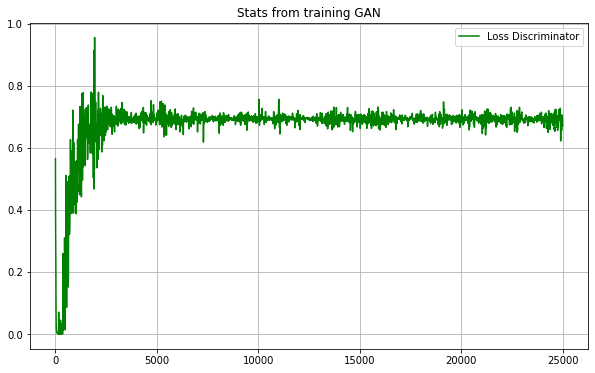

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.plot(Loss['Loss Discriminator'],color="g",label='Loss Discriminator')
#plt.plot(Loss['Loss Generator'],color="r",label='Loss Generator')
plt.title("Stats from training GAN") 
plt.grid()
plt.legend()

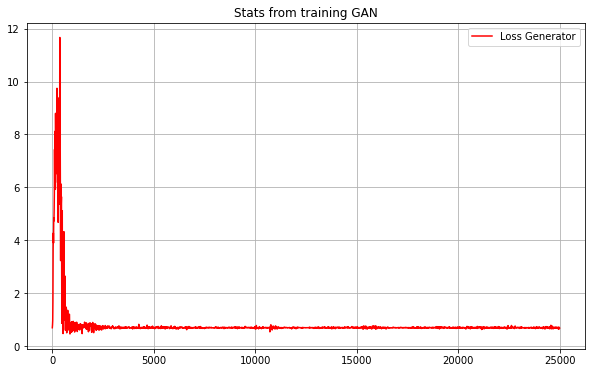

In [22]:
fig = plt.figure(figsize=(10, 6))
#plt.plot(Loss['Loss Discriminator'],color="g",label='Loss Discriminator')
plt.plot(Loss['Loss Generator'],color="r",label='Loss Generator')
plt.title("Stats from training GAN") 
plt.grid()
plt.legend()

In [23]:
# Specify a path
PATH = "entire_model_3D.pt"

# Save
torch.save(generator, PATH)

In [24]:
#Load model
model = torch.load(PATH)
model.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)

### Generate Samples:

In [25]:
latent_space_samples = torch.randn(1000, 3)
generated_samples = model(latent_space_samples)

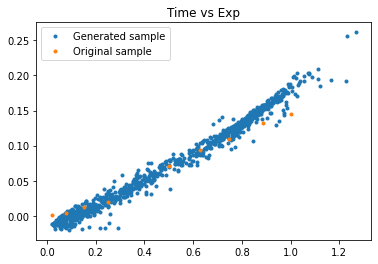

In [26]:
# Visualize generated samples
#time vs exp
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".", label='Generated sample')
plt.plot(train_data[:, 0], train_data[:, 1], ".", label='Original sample')
plt.title("Time vs Exp") 
plt.legend()

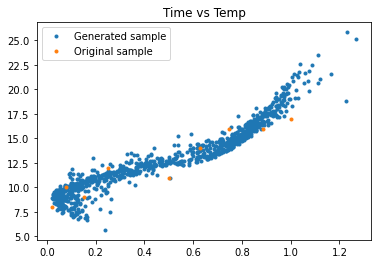

In [27]:
# Visualize generated samples
#time vs Temp
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 2], ".", label='Generated sample')
plt.plot(train_data[:, 0], train_data[:, 2], ".", label='Original sample')
plt.title("Time vs Temp") 
plt.legend()

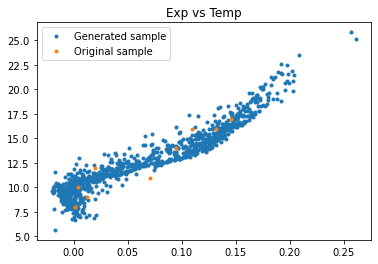

In [28]:
# Visualize generated samples
#exp vs temp
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 1], generated_samples[:, 2], ".", label='Generated sample')
plt.plot(train_data[:, 1], train_data[:, 2], ".", label='Original sample')
plt.title("Exp vs Temp") 
plt.legend()

/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


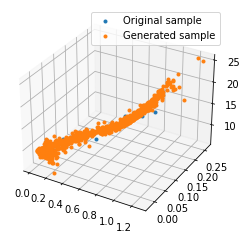

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(train_data[:, 0], train_data[:, 1], train_data[:, 2], ".", label='Original sample')
ax.plot(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], ".", label='Generated sample')
plt.legend()

### Generate the Dataset:

In [30]:
#(generated_samples[:, 0], generated_samples[:, 1])
t1=generated_samples[:, 0]
t2=generated_samples[:, 1]
t3=generated_samples[:, 2]

x1=t1.unsqueeze(dim=1)
x2=x1.numpy()

x3=t2.unsqueeze(dim=1)
x4=x3.numpy()

x5=t3.unsqueeze(dim=1)
x6=x5.numpy()


df1 = pd.DataFrame(x2) #convert to a dataframe

df2 = pd.DataFrame(x4) #convert to a dataframe

df3 = pd.DataFrame(x6) #convert to a dataframe

data_synthetic = pd.concat([df1, df2, df3], axis=1)

# adding column name to the respective columns
data_synthetic.columns =['Time', 'Exp', 'Temp']
data_synthetic.sort_values(by=['Time'], inplace=True)
data_synthetic

,Time,Exp,Temp
307,0.022128,-0.011641,8.965065
140,0.022847,-0.012191,9.352649
945,0.023650,-0.011879,9.216819
569,0.024057,-0.011023,8.856339
816,0.026897,-0.011591,9.309155
...,...,...,...
323,1.121649,0.184434,21.104151
572,1.165402,0.192978,21.571161
852,1.225234,0.192028,18.816366
574,1.230429,0.256871,25.826780


### Check data quality:

In [31]:
def find_neighbours(value, df):
    exactmatch=df.iloc[(df['Time']-value).abs().argsort()[:1]].values
    return exactmatch

In [32]:
numbers = list(df_raw['Time'])
x = {}
for i in range(len(numbers)):
    x[i] = pd.DataFrame(find_neighbours(numbers[i],data_synthetic))

final = pd.concat(x.values(),ignore_index=True)

In [33]:
final

,0,1,2
0,0.022128,-0.011641,8.965065
1,0.076707,-0.003561,8.774924
2,0.152611,0.004763,10.686282
3,0.251338,0.013891,11.697665
4,0.501014,0.069602,13.077940
5,0.628412,0.104027,13.059860
6,0.747877,0.120559,14.389857
7,0.885944,0.157751,16.666283
8,0.998441,0.187945,19.056383


In [34]:
final.columns =['t', 'gen exp', 'gen temp']

In [35]:
final

,t,gen exp,gen temp
0,0.022128,-0.011641,8.965065
1,0.076707,-0.003561,8.774924
2,0.152611,0.004763,10.686282
3,0.251338,0.013891,11.697665
4,0.501014,0.069602,13.077940
5,0.628412,0.104027,13.059860
6,0.747877,0.120559,14.389857
7,0.885944,0.157751,16.666283
8,0.998441,0.187945,19.056383


In [36]:
final.index = (final['t'])
final

,t,gen exp,gen temp
t,,,
0.022128,0.022128,-0.011641,8.965065
0.076707,0.076707,-0.003561,8.774924
0.152611,0.152611,0.004763,10.686282
0.251338,0.251338,0.013891,11.697665
0.501014,0.501014,0.069602,13.077940
0.628412,0.628412,0.104027,13.059860
0.747877,0.747877,0.120559,14.389857
0.885944,0.885944,0.157751,16.666283
0.998441,0.998441,0.187945,19.056383


In [37]:
df_org=df_raw

In [38]:
df_org

,Time,Exp,Temp
0,0.019812,0.001000,8
1,0.076607,0.004000,10
2,0.153213,0.012340,9
3,0.250953,0.019480,12
4,0.500585,0.070780,11
5,0.628234,0.094455,14
6,0.747575,0.110000,16
7,0.885994,0.131614,16
8,0.999849,0.145450,17


In [39]:
df_org.index = (df_org['Time'])
df_org

,Time,Exp,Temp
Time,,,
0.019812,0.019812,0.001000,8
0.076607,0.076607,0.004000,10
0.153213,0.153213,0.012340,9
0.250953,0.250953,0.019480,12
0.500585,0.500585,0.070780,11
0.628234,0.628234,0.094455,14
0.747575,0.747575,0.110000,16
0.885994,0.885994,0.131614,16
0.999849,0.999849,0.145450,17


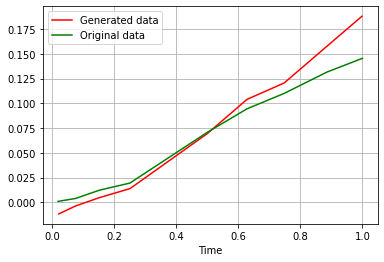

In [40]:
final['gen exp'].plot(color="r", label='Generated data')
df_org['Exp'].plot(color="g", label='Original data')
plt.grid()
plt.legend()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(final['gen exp'],df_org['Exp']))
print(rmse)

0.018254719851280757


In [42]:
df_org = np.float32(df_org)
df_org=torch.from_numpy(df_org)
torch.set_printoptions(precision=5)
df_org

tensor([[1.98121e-02, 1.00000e-03, 8.00000e+00],
        [7.66067e-02, 4.00000e-03, 1.00000e+01],
        [1.53213e-01, 1.23400e-02, 9.00000e+00],
        [2.50953e-01, 1.94800e-02, 1.20000e+01],
        [5.00585e-01, 7.07800e-02, 1.10000e+01],
        [6.28234e-01, 9.44546e-02, 1.40000e+01],
        [7.47575e-01, 1.10000e-01, 1.60000e+01],
        [8.85994e-01, 1.31614e-01, 1.60000e+01],
        [9.99849e-01, 1.45450e-01, 1.70000e+01]])

In [43]:
final = np.float32(final)
final=torch.from_numpy(final)
torch.set_printoptions(precision=5)
final

tensor([[ 2.21276e-02, -1.16405e-02,  8.96507e+00],
        [ 7.67070e-02, -3.56130e-03,  8.77492e+00],
        [ 1.52611e-01,  4.76299e-03,  1.06863e+01],
        [ 2.51338e-01,  1.38905e-02,  1.16977e+01],
        [ 5.01014e-01,  6.96021e-02,  1.30779e+01],
        [ 6.28412e-01,  1.04027e-01,  1.30599e+01],
        [ 7.47877e-01,  1.20559e-01,  1.43899e+01],
        [ 8.85944e-01,  1.57751e-01,  1.66663e+01],
        [ 9.98441e-01,  1.87945e-01,  1.90564e+01]])

/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/asif/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


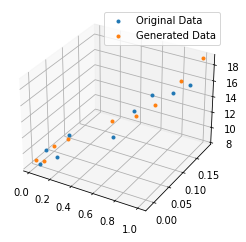

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot(df_org[:, 0], df_org[:, 1], df_org[:, 2], ".", label='Original Data')
ax1.plot(final[:, 0], final[:, 1], final[:, 2], ".", label='Generated Data')
plt.legend()

### Save Data:

In [45]:
data_synthetic["Time"]*31536000 #years to seconds

307    6.978159e+05
140    7.205132e+05
945    7.458374e+05
569    7.586541e+05
816    8.482082e+05
           ...     
323    3.537233e+07
572    3.675213e+07
852    3.863898e+07
574    3.880281e+07
794    4.000134e+07
Name: Time, Length: 1000, dtype: float64

In [46]:
(data_synthetic['Time']*31536000).tolist()

[697815.9470558167,
 720513.22889328,
 745837.3804092407,
 758654.0608406067,
 848208.2304954529,
 855092.6027297974,
 890789.3650531769,
 890824.6092796326,
 939466.3410186768,
 950300.4162311554,
 969623.6507892609,
 970928.6270141602,
 984588.3493423462,
 1040246.5016841888,
 1044488.4967803955,
 1069743.569612503,
 1131295.0265407562,
 1131830.2688598633,
 1145713.2046222687,
 1154387.5136375427,
 1161302.9007911682,
 1168418.475151062,
 1177628.4964084625,
 1179841.8338298798,
 1180129.8966407776,
 1183486.086845398,
 1248965.160369873,
 1280535.5286598206,
 1285744.155406952,
 1309406.1892032623,
 1316582.8535556793,
 1321803.228378296,
 1328808.3708286285,
 1329849.2503166199,
 1359208.1608772278,
 1360880.1469802856,
 1365294.6038246155,
 1388592.4472808838,
 1393611.6950511932,
 1411264.353275299,
 1430456.9492340088,
 1453751.0333061218,
 1468661.2207889557,
 1478301.2216091156,
 1498741.4631843567,
 1503112.6871109009,
 1519226.3474464417,
 1522288.3658409119,
 1526446.71463

In [47]:
XX=[(pd.to_datetime(

    (data_synthetic['Time']*31536000).tolist(), unit="s"

)+pd.DateOffset(years=52)), data_synthetic['Exp']]


#)-pd.Timestamp("1970-01-01")

In [48]:
p=(pd.to_datetime(

    (data_synthetic['Time']*31536000).tolist(), unit="s"

)+pd.DateOffset(years=52))


In [49]:
q=p.floor('S').tz_localize(None)

In [50]:
XX=[q, data_synthetic['Exp'], data_synthetic['Temp']]
XX

[DatetimeIndex(['2022-01-09 01:50:15', '2022-01-09 08:08:33',
                '2022-01-09 15:10:37', '2022-01-09 18:44:14',
                '2022-01-10 19:36:48', '2022-01-10 21:31:32',
                '2022-01-11 07:26:29', '2022-01-11 07:27:04',
                '2022-01-11 20:57:46', '2022-01-11 23:58:20',
                ...
                '2023-01-28 17:35:18', '2023-01-29 01:43:05',
                '2023-02-01 10:26:18', '2023-02-10 20:41:30',
                '2023-02-11 05:14:17', '2023-02-14 09:38:54',
                '2023-03-02 08:55:30', '2023-03-24 05:03:00',
                '2023-03-26 02:33:26', '2023-04-08 23:28:56'],
               dtype='datetime64[ns]', length=1000, freq=None),
 307   -0.011641
 140   -0.012191
 945   -0.011879
 569   -0.011023
 816   -0.011591
          ...   
 323    0.184434
 572    0.192978
 852    0.192028
 574    0.256871
 794    0.261615
 Name: Exp, Length: 1000, dtype: float32,
 307     8.965065
 140     9.352649
 945     9.216819
 569     8.8

In [51]:
YY=pd.DataFrame(XX)
ZZ=YY.T

In [52]:
ZZ.columns =['Datetime', 'exp', 'temp']
ZZ.sort_values(by=['Datetime'], inplace=True)
ZZ

,Datetime,exp,temp
0,2022-01-09 01:50:15,-0.011641,8.965065
1,2022-01-09 08:08:33,-0.012191,9.352649
2,2022-01-09 15:10:37,-0.011879,9.216819
3,2022-01-09 18:44:14,-0.011023,8.856339
4,2022-01-10 19:36:48,-0.011591,9.309155
...,...,...,...
995,2023-02-14 09:38:54,0.184434,21.104151
996,2023-03-02 08:55:30,0.192978,21.571161
997,2023-03-24 05:03:00,0.192028,18.816366
998,2023-03-26 02:33:26,0.256871,25.82678


In [53]:
ZZ.to_csv("data_synthetic_3D",index=False) #save to file as data_synthetic.csv

Now, let's read the saved csv file to see if it is working.

In [54]:
df3 = pd.read_csv("data_synthetic_3D")
df3

,Datetime,exp,temp
0,2022-01-09 01:50:15,-0.011641,8.965065
1,2022-01-09 08:08:33,-0.012191,9.352649
2,2022-01-09 15:10:37,-0.011879,9.216819
3,2022-01-09 18:44:14,-0.011023,8.856339
4,2022-01-10 19:36:48,-0.011591,9.309155
...,...,...,...
995,2023-02-14 09:38:54,0.184434,21.104151
996,2023-03-02 08:55:30,0.192978,21.571161
997,2023-03-24 05:03:00,0.192028,18.816366
998,2023-03-26 02:33:26,0.256871,25.826780


In [55]:
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:09:24.821677


### References:

1. Goodfellow, Ian; Pouget-Abadie, Jean; Mirza, Mehdi; Xu, Bing; Warde-Farley, David; Ozair, Sherjil; Courville, Aaron; Bengio, Yoshua. Generative Adversarial Nets (PDF). Proceedings of the International Conference on Neural Information Processing Systems (NIPS 2014). pp. 2672–2680.
2. Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J., Dive into Deep Learning. arXiv preprint arXiv:2106.11342.(2021). https://d2l.ai/index.html
3. V.E. Saouma, R.A. Martin, M.A. Hariri-Ardebili, T. Katayama, A mathematical model for the kinetics of the alkali-silica chemical reaction, Cem. Concr. Res. 68 (2015) 184–195.
4. Md. Asif Rahman, Yang Lu, A time-dependent chemo-mechanical analysis of alkali-silica reaction for the disparate geometry of concrete meso-structure, Construction and Building Materials, Volume 211, 2019, Pages 847-857, ISSN 0950-0618. https://doi.org/10.1016/j.conbuildmat.2019.03.025.
5. Jason Brownlee, Generative Adversarial Networks, July 8, 2019. https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

"Thank You"